#### COLLABORATIVE FILTERING MODEL WITH NEURAL NETWORK

In [104]:
PATH = '/home/g056122/DAFERS'
DATAPATH = '/home/g056122/ISG_studienarbeit/ml-1m'

In [105]:
'''  
Load 'base' module from 'module' folder
'''
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from base import basedata

In [106]:
# load users data preparation pickle file
[df, dftrain, dftest, df, dfratings, idx_to_user, idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{PATH}/1UsersData.pkl','rb'))

In [107]:
# split data to train-test data
dftrain=df.loc[df['train']=='train']
dftest=df.loc[df['train']!='train']

DATASET AND DATALOADER

In [108]:
# load dataset for model
dstrain=basedata(dftrain[['user_idx','movie_idx']],dftrain['rating'])
dstest=basedata(dftest[['user_idx','movie_idx']],dftest['rating'])

In [109]:
# batch size
bs=128
# load dataloader object for train-test data
dltrain=DataLoader(dstrain,bs,True)
dltest=DataLoader(dstest,bs,True)

MODEL ARCHITECTURE

In [110]:
# model parameters
n_users=len(user_to_idx)
n_movies=len(movie_to_idx)
n_emb_user=50
n_emb_movie=50
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05
hidden=[25,10]
dropouts=[0.2,0.2]

In [111]:
# subclass for neural network module
class baseline(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        # call parent class constructor
        super().__init__()
        self.n_users, self.n_emb_user, self.n_emb_item, self.n_items, self.min_rating, self.max_rating = \
                    n_users, n_emb_user, n_emb_item, n_items, min_rating, max_rating
        self.dropout_e, self.hidden, self.dropouts = \
            dropout_e, hidden, dropouts
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        ''' 
        Function to build model architecture
        '''
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        self.sigmoid=nn.Sigmoid()
        
    def init_parameters(self):
        ''' 
        Function to initialize the weights for the layers
        '''
        # kimining normalization to initialize the weights
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

       
    def forward (self,Xb,Yb):   
        ''' 
        Function to perform forward pass
        '''            
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))
        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

MODEL LEARNER

In [112]:
class model_learner():
    def __init__(self, model, optimizer, metric_fn, bptt=12, print_every=5, clip_val=None,\
                 cycle_mult=0, lr_decay=0.7, wd_mult=6, start_lr=2e-2, end_lr=5e-4):
        self.model, self.optimizer, self.metric_fn, self.print_every, self.bptt, self.losses, self.clip_val=\
                model, optimizer, metric_fn, print_every, bptt,[], clip_val
        self.n_epochs=1
        self.cycle_mult, self.lr_decay = cycle_mult, lr_decay
        self.wd_mult = wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr = param_group['lr']
            self.start_wd = param_group['weight_decay']
        self.wd = self.start_wd
        self.lr = self.start_lr
        self.end_lr = end_lr
        self.n_epoch = 0
        self.lrs = [1e-2,5e-3,1e-4,5e-4]
        self.preds, self.preds_test, self.trainY, self.actual = [], [], [], []
        self.ratio = self.end_lr / self.start_lr
        self.num_steps = self.cycle_mult
        self.reset_cycle = self.cycle_mult
        
    def fit (self, Xb, Yb, mode_train = True):
        ''' 
        Function to make predictions and compute loss
        '''
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        preds, loss = self.model ( Xb, Yb)

        with torch.no_grad():
            if self.metric_fn is not None:
                acc = self.metric_fn(preds,Yb.view(-1))
                acc = acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_test.append(preds.data)
            else:
                acc=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            # clear gradients of all optimized parameters
            self.optimizer.zero_grad()
            # compute gradients of loss with respect to parameters of neural network
            loss.backward()
            # optimizer updates the parameters
            self.optimizer.step()
        # MSE and RMSE
        myloss = loss.item()
        acc = np.sqrt(myloss)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        ''' 
        Function to determine optimal learning rate 
        '''
        losses, lrs = [], []
        ratio = end_lr/start_lr
        num_steps = n_batch
        lr = start_lr
        for i in range(num_steps):            
            lr = lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs = lrs
        self.run_epoch(iterator, mode_train = True, lrs = lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        ''' 
        Function to train the model for one epoch
        '''
        epoch_loss, epoch_acc, i, k = 0, 0, 0, 0

        for Xb, Yb in iterator:
            Xb = Xb
            Yb = Yb
            
            if lrs is not None:
                lr = lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = lr 
            
            loss, acc = self.fit(Xb, Yb, mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
            
        return epoch_loss, epoch_acc
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        ''' 
        Function to plot graph of learning rate vs loss
        '''
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dltest,n_epochs=1):  
        ''' 
        Function to run epoch for n_epochs
        '''            
        for epoch in range(n_epochs):                
            loss, acc = self.run_epoch(dltrain,True)
            lossv, accv = self.run_epoch(dltest, mode_train = False)
            print (f'Epoch:{epoch+1} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} Test Loss:{lossv} Train RMSE:{acc} Test RMSE:{accv}')
  
            if self.cycle_mult:
                if self.n_epoch == self.reset_cycle:
                    self.lr = self.start_lr
                    self.reset_cycle*=self.cycle_mult
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    self.lr=self.lr*(self.ratio)**(1/self.num_steps)
                    self.n_epoch+=1
                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr     

In [113]:
# model architecture object
baseobj = baseline(n_users, n_emb_user, n_emb_movie, n_movies, min_rating, max_rating, dropout_e)
# optimizer
optimizer = torch.optim.Adam(baseobj.parameters(), lr=5e-3, betas=(0.9,0.999), weight_decay=1e-5)
# model learner object
learner = model_learner(baseobj, optimizer, None, 0, 16000, 0.25, cycle_mult=0)

In [114]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

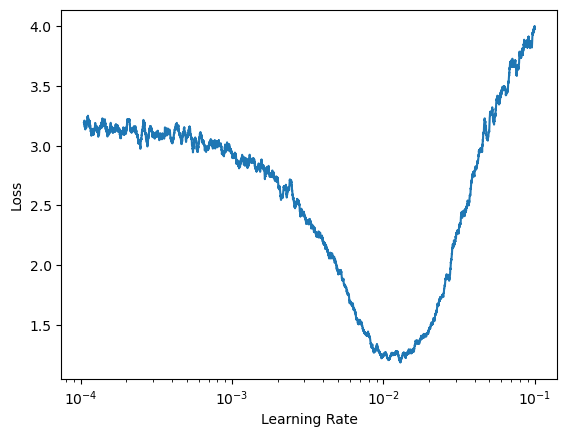

In [115]:
learner.plot_lrs(50)

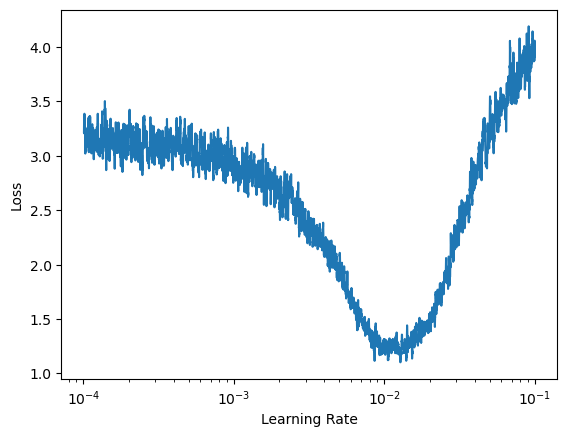

In [116]:
learner.plot_lrs(10)

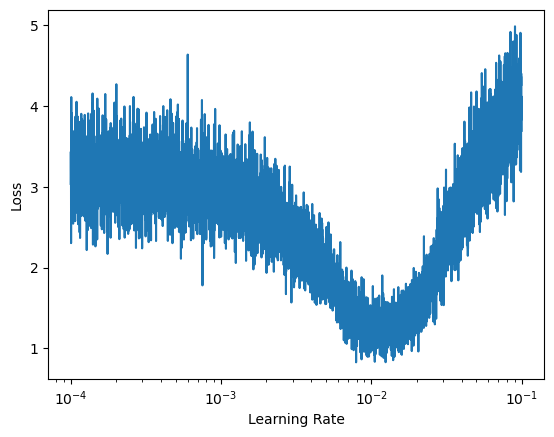

In [117]:
learner.plot_lrs(1)

In [118]:
# model architecture object
baseobj = baseline(n_users, n_emb_user, n_emb_movie, n_movies, min_rating, max_rating, dropout_e)
# optimizer
optimizer = torch.optim.Adam(baseobj.parameters(), lr=5e-3, betas=(0.9,0.999), weight_decay=1e-5)
# model learner object
learner = model_learner(baseobj, optimizer, None, 0, 16000, 0.25, cycle_mult=0)

In [119]:
learner.run_epochs(dltrain, dltest, 10)

Epoch:1 Learning rate 0.005 Weight Decay 1e-05 Train Loss:1.188078271847742 Test Loss:0.8382896608708764 Train RMSE:1.067759811588911 Test RMSE:0.9134090384216285
Epoch:2 Learning rate 0.005 Weight Decay 1e-05 Train Loss:0.7898443803650953 Test Loss:0.8046865921724787 Train RMSE:0.8865487828762331 Test RMSE:0.8946760832166638
Epoch:3 Learning rate 0.005 Weight Decay 1e-05 Train Loss:0.7450529324937203 Test Loss:0.8019651715712779 Train RMSE:0.8607109707535593 Test RMSE:0.893097477572786
Epoch:4 Learning rate 0.005 Weight Decay 1e-05 Train Loss:0.7300171378190057 Test Loss:0.7980578855785263 Train RMSE:0.8519343375570918 Test RMSE:0.8911963650409327
Epoch:5 Learning rate 0.005 Weight Decay 1e-05 Train Loss:0.7205913595449496 Test Loss:0.8053859836610077 Train RMSE:0.8462657045215303 Test RMSE:0.8952225234911946
Epoch:6 Learning rate 0.005 Weight Decay 1e-05 Train Loss:0.7169172097096551 Test Loss:0.8044032799008557 Train RMSE:0.8440815167725002 Test RMSE:0.8945479594918221
Epoch:7 Learn

SAVE MODEL OBJECTS AND PARAMETERS

In [120]:
torch.save(baseobj, f=f'{PATH}/4BaseModel')
torch.save(learner,f=f'{PATH}/BaseLearner')
torch.save(optimizer,f=f'{PATH}/4BaseOptimizer')
torch.save(baseobj.state_dict(),f'{PATH}/4BaseStateDict')
torch.save(optimizer.state_dict(),f'{PATH}/4BaseOptimizerStateDict')

PRETRAINED WEIGHTS FOR THE MODEL

In [121]:
# embeddings weights
mtx_userembed=baseobj.emb_user.weight.data.numpy()
mtx_itemembed=baseobj.emb_item.weight.data.numpy()
user_biasembed=baseobj.ub.weight.data.numpy()
item_biasembed=baseobj.ib.weight.data.numpy()

In [122]:
# save embeddings weights pickle file
pickle.dump([mtx_userembed,mtx_itemembed,user_biasembed,item_biasembed],open(f'{PATH}/4BaseEmbeddingsWeights','wb'))